#  目的
subの17のCVを計算する

In [15]:
# path setting
EXP_NAME = "e017-calc-cv"
MODEL_NAME = "microsoft/deberta-v3-xsmall"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = False
UPLOAD_DATA_TO_S3 = False
UPLOAD_DATA_TO_KAGGLE = False
WANDB = False

# model parameter
# TRAINING_MAX_LENGTH= 512
TRAINING_MAX_LENGTH= 1024
INFERENCE_MAX_LENGTH = 1536
SEED = 42
EPOCH = 4
LR = 2e-05
TRAIN_BS =  8
GRAD_ACC_NUM = 16
EVAL_BS =  8
SAVE_STEP = 0.1
EVAL_STEP = 0.1
LR_SCHE_TYPE = "linear"

TRAINED_MODEL_PATH= "/notebooks/" + "automated_essay_scoring/trained_models/e009-max-token-1024"

In [16]:
!nvidia-smi

Sun May 19 01:12:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   46C    P8    22W / 300W |      3MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
!python --version

Python 3.11.7


In [18]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e017-calc-cv


In [19]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [20]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [21]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from tokenizers import AddedToken
from sklearn.metrics import cohen_kappa_score

In [22]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [23]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [24]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [25]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [26]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'none'

# Data Import

In [27]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [28]:
if DEBUG:
    train_dataset = train_dataset.select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [29]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(AddedToken("\n", normalized=False)) 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


1

In [30]:
def preprocess_function(examples, max_token_length: int):
    return tokenizer(
        examples["full_text"],
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


In [31]:
train_dataset = train_dataset.rename_column("score", "labels")

In [32]:
set(train_dataset["labels"])

{1, 2, 3, 4, 5, 6}

In [33]:
with open(f"{DATA_PATH}/essay_id_fold_dict.json") as f:
    essay_id_fold_dict = json.load(f)

In [34]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17307
})

In [35]:
train_dataset = train_dataset.map(
    lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
)

train_test_split_dataset = DatasetDict(
    {
        "train": train_dataset.filter(lambda x: x["fold"] != 2, num_proc=NUM_PROC),
        "valid": train_dataset.filter(lambda x: x["fold"] == 2, num_proc=NUM_PROC),
    }
)

# Check
assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
assert set(train_test_split_dataset["valid"]["fold"]) == {2}

if not DEBUG:
    essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
    assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
    assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

In [36]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [37]:
import numpy as np
import scipy as sp
from functools import partial

# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_['x']

# optR = OptimizedRounder()
# optR.fit(valid_pred, valid_dataset["labels"])
# print(optR.coefficients)

# optimized = optR.predict(valid_pred, optR.coefficients)

In [38]:
# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


from sklearn.metrics import mean_squared_error
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred
    mse = mean_squared_error(labels, predictions)
    return {"mse": mse}

def compute_metrics_for_regression_opt(eval_pred):
    predictions, labels = eval_pred
    
    optR = OptimizedRounder()
    optR.fit(predictions, labels)
    optimized = optR.predict(predictions, optR.coefficients)
    print(optR.coefficients)
    
    qwk = cohen_kappa_score(labels, optimized, weights="quadratic")
    return {"qwk": qwk}

In [39]:
# regression
# https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

# cast labels to float for regression
train_test_split_dataset = DatasetDict(
    {
        "train": train_test_split_dataset["train"].cast_column(
            "labels", Value(dtype="float")
        ),
        "valid": train_test_split_dataset["valid"].cast_column(
            "labels", Value(dtype="float")
        ),
    }
)
print(train_test_split_dataset)

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 11538
    })
    valid: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 5769
    })
})


In [40]:
# if not DEBUG:
#     assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
#     assert len(set(train_test_split_dataset["valid"]["labels"])) == NUM_LABELS

In [41]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEP,
    save_strategy="steps",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    # metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type=LR_SCHE_TYPE,
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics_for_regression,
    compute_metrics=compute_metrics_for_regression_opt
)

In [42]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=1,
        problem_type="regression",
    )
    
    args = TrainingArguments(
        ".", 
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model, 
        args=args,
        data_collator=data_collator, 
        tokenizer=tokenizer,
    )

# valid_datasetの作成・保存

In [43]:
# valid_dataset = train_test_split_dataset["valid"]
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset =  train_dataset.filter(
    lambda example: example["essay_id"] in train_test_split_dataset["valid"]["essay_id"],
    num_proc=NUM_PROC,
)

valid_dataset = valid_dataset.cast_column("labels", Value(dtype="float"))

valid_dataset = valid_dataset.map(
    preprocess_function,
    batched=True,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC
)

def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = trainer.predict(valid_dataset).predictions.flatten()

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

In [44]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/5769 [00:00<?, ? examples/s]

# CVの計算

In [45]:
# for regression
def clip_valid_pred(example):
    # 四捨五入を実施
    example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
    return example

valid_dataset = valid_dataset.map(clip_valid_pred)

cv_score = cohen_kappa_score(
    valid_dataset["labels"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score by round: {cv_score}")

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

CV Score by round: 0.811610675833487


In [46]:
optR = OptimizedRounder()
optR.fit(valid_pred, valid_dataset["labels"])
print(optR.coefficients)

optimized = optR.predict(valid_pred, optR.coefficients)

[1.53095607 2.6729389  3.53490965 4.49384664 5.37552482]


In [47]:
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [48]:
cv_score = cohen_kappa_score(
    valid_dataset["labels"], optimized, weights="quadratic"
)

print(f"CV Score by NelderMead: {cv_score}")

CV Score by NelderMead: 0.8218719169794032


In [49]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

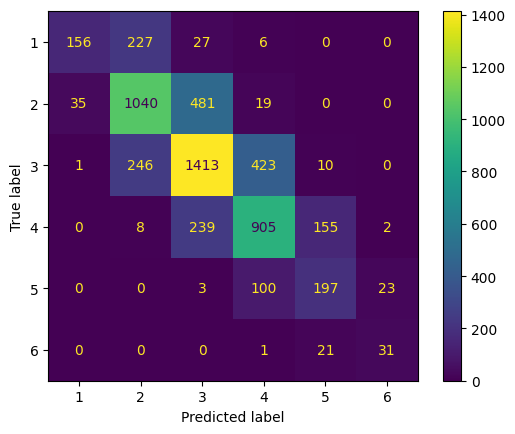

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["labels"],
    valid_dataset["valid_pred"],
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [51]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

In [52]:
# # ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e009-max-token-1024 /notebooks/automated_essay_scoring/trained_models/e009-max-token-1024

# Kaggle Datasetへのupload

In [53]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [54]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [55]:
if WANDB:
    wandb.finish()

In [56]:
print("finish Notebook!")

finish Notebook!
